In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from skimage import morphology
import matplotlib.image as mpimg
import random
from sklearn.cluster import KMeans
import cv2
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
import os
from PIL import ImageColor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [2]:
features = pd.read_csv(r'../features/features.csv')
ground_truth = pd.read_csv(r"../data/example_ground_truth.csv")


## Functions

In [3]:
def calculate_area(image):
    """
    image = a numpy array
    """
    return np.sum(image)

def calculate_border(image,thickness):
    """
    image = np array of a picture
    thicness = an integer of the thiccness of the border
    returns = the border of the figure
    """
    struct_el = morphology.disk(thickness)
    mask_eroded = morphology.binary_erosion(image, struct_el)
    return calculate_area(image)-np.sum(mask_eroded)


def compactness(area, border):
    """
    area = the area of the figure
    border = the circumference of the figure
    return = returns the compactness
    """
    top = border**2
    bot = 4*math.pi*area
    return top/bot

def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))



def average_colour(image,segmentation):
    mask = segmentation == 1
    copy = image.copy()
    r = np.mean(copy[mask,0])
    g = np.mean(copy[mask,1])
    b = np.mean(copy[mask,2])
    #num_of_pixels = copy[mask].shape[0]
    return [r,g,b]

def deviation_of_colour(image,segmentation):
    mask = segmentation == 1
    copy = image.copy()
    r = np.std(copy[mask,0])
    g = np.std(copy[mask,1])
    b = np.std(copy[mask,2])
    return [r,g,b]

def average_luminosity(image,segmentation):
    avg_colour = average_colour(image,segmentation)
    return 0.299*avg_colour[0] + 0.587*avg_colour[1] + 0.114*avg_colour[2]

def deviation_luminosity(image,segmentation):
    deviation_colour = deviation_of_colour(image,segmentation)
    return np.sqrt(0.299**2*deviation_colour[0]**2 + 0.587**2*deviation_colour[1]**2 + 0.114**2*deviation_colour[2]**2)

def findImage(image_id):
    image = plt.imread('../data/example_image/'+image_id+'.jpg')
    image_seg = plt.imread('../data/example_segmentation/'+image_id+'_segmentation.png')
    return image,image_seg

def make_knn_prediction(k):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(x_train, y_train)
    return neigh.predict(x_test)

def from_rgb_to_int(df):
    placeholder = [RGB2HEX(elm) for elm in df]
    hex_val = [int("0x" + elm[1:],0) for elm in placeholder]
    return hex_val

def knn_model_constructor(k,training,labels):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(training, labels)
    return model

## Here we load in the data

In [4]:
#Reading ground truth
ground_truth = pd.read_csv("../data/example_ground_truth.csv")

In [5]:
#read file features
file_features_df = pd.read_csv("../features/features.csv")

In [6]:
#rename column 'id' to 'image_id'
file_features_df.rename(columns={'id': 'image_id'}, inplace=True)

In [7]:
#rename column 'id' to 'image_id'
file_features_df.rename(columns={'id': 'image_id'}, inplace=True)

In [8]:
all_feature_merge = file_features_df.merge(ground_truth, on='image_id', how='right')

In [9]:
all_feature_merge

,image_id,area,perimeter,melanoma,seborrheic_keratosis
0,ISIC_0001769,216160.0,2013.0,0.0,0.0
1,ISIC_0001852,130493.0,1372.0,0.0,0.0
2,ISIC_0001871,205116.0,1720.0,0.0,0.0
3,ISIC_0003462,161705.0,1344.0,0.0,0.0
4,ISIC_0003539,317040.0,2063.0,0.0,0.0
...,...,...,...,...,...
145,ISIC_0015443,9732988.0,13775.0,0.0,0.0
146,ISIC_0015445,12049938.0,19517.0,0.0,0.0
147,ISIC_0015483,8856478.0,13813.0,0.0,0.0
148,ISIC_0015496,8951522.0,13742.0,0.0,0.0


In [10]:
label = []
for elm in zip(all_feature_merge['melanoma'],all_feature_merge['seborrheic_keratosis']):
    
    if elm[0] == 1.0:
        #print("hej")
        label.append(1.0)
    if elm[1] == 1.0:
        label.append(2.0)
    if (elm[0] == 0.0) and (elm[1] == 0.0):
        label.append(0)
    #print(type(elm[0]))
#len(label)
all_feature_merge['label'] = label

In [12]:
label = []
for elm in zip(all_feature_merge['melanoma'],all_feature_merge['seborrheic_keratosis']):
    
    if elm[0] == 1.0 or elm[1] == 1.0:
        #print("hej")
        label.append(1.0)
    else:
        label.append(0.0)
    print(type(elm[0]))
all_feature_merge['label'] = label

In [13]:
all_feature_merge['label']

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
145    0.0
146    0.0
147    0.0
148    0.0
149    0.0
Name: label, Length: 150, dtype: float64

In [14]:

#Export features from images
data = pd.DataFrame()
count = 0
rows = []
for image_id in all_feature_merge['image_id']:
    print(image_id,count)
    
    image = plt.imread('../data/example_image/'+image_id+'.jpg')
    image_seg = plt.imread('../data/example_segmentation/'+image_id+'_segmentation.png')
    #data['image_id'] = image_id
    real_area = int(all_feature_merge[all_feature_merge['image_id'] == image_id]['area'])
    real_perimeter = int(all_feature_merge[all_feature_merge['image_id'] == image_id]['perimeter'])
    thing = all_feature_merge['image_id'] == image_id
    label = int(all_feature_merge[thing]['label'])

    calculated_area = int(calculate_area(image_seg))
    calculated_perimeter = calculate_border(image_seg,2)
    imgCompactness = compactness(calculate_area(image_seg),calculate_border(image_seg,1))
    average_rgb = average_colour(image,image_seg)
    deviation_of_rgb = deviation_of_colour(image,image_seg)
    average_luminosity_img = average_luminosity(image,image_seg)
    deviation_luminosity_img = deviation_luminosity(image,image_seg)
    row = [label,image_id, real_area, real_perimeter,calculated_area,calculated_perimeter,imgCompactness,average_rgb,deviation_of_rgb,average_luminosity_img,deviation_luminosity_img]
    rows.append(row)
    count+= 1

data = pd.DataFrame(rows, columns = ['label','image_id','real_area','real_perimeter','calculated_area','calculated_perimeter','compactness','average_rgb','deviation_of_colour','average_luminosity','deviation_luminosity'])

ISIC_0001769 0
ISIC_0001852 1
ISIC_0001871 2
ISIC_0003462 3
ISIC_0003539 4
ISIC_0003582 5
ISIC_0003657 6
ISIC_0003805 7
ISIC_0004337 8
ISIC_0006651 9
ISIC_0006671 10
ISIC_0006815 11
ISIC_0006914 12
ISIC_0007141 13
ISIC_0007156 14
ISIC_0007235 15
ISIC_0007241 16
ISIC_0007332 17
ISIC_0007344 18
ISIC_0007528 19
ISIC_0007796 20
ISIC_0008025 21
ISIC_0008524 22
ISIC_0009995 23
ISIC_0010459 24
ISIC_0012099 25
ISIC_0012109 26
ISIC_0012126 27
ISIC_0012127 28
ISIC_0012143 29
ISIC_0012151 30
ISIC_0012159 31
ISIC_0012160 32
ISIC_0012191 33
ISIC_0012201 34
ISIC_0012204 35
ISIC_0012206 36
ISIC_0012210 37
ISIC_0012221 38
ISIC_0012222 39
ISIC_0012254 40
ISIC_0012256 41
ISIC_0012288 42
ISIC_0012306 43
ISIC_0012313 44
ISIC_0012316 45
ISIC_0012335 46
ISIC_0012380 47
ISIC_0012383 48
ISIC_0012400 49
ISIC_0012417 50
ISIC_0012434 51
ISIC_0012492 52
ISIC_0012513 53
ISIC_0012538 54
ISIC_0012547 55
ISIC_0012660 56
ISIC_0012684 57
ISIC_0012720 58
ISIC_0012746 59
ISIC_0012876 60
ISIC_0012927 61
ISIC_0012956 62
IS

In [108]:
Counter(data['label'])

Counter({0: 78, 1: 30, 2: 42})

In [ ]:
#Here we create a backup

In [106]:
backup = data.copy()

In [100]:
sick = data.copy()

In [101]:
mask = (sick['label'] == 1) | (sick['label'] == 2)

In [102]:
# This is the df only containing melanoma or keratosis
sick_df = sick_or_not[mask]

In [109]:
label = []
for elm in zip(all_feature_merge['melanoma'],all_feature_merge['seborrheic_keratosis']):
    
    if elm[0] == 1.0 or elm[1] == 1.0:
        #print("hej")
        label.append(1.0)
    else:
        label.append(0.0)
    
data['label'] = label

In [ ]:
#Now data is the df containing melanoma and keratosis as 1 and nothing as 0 

In [110]:
Counter(data['label'])

Counter({0.0: 78, 1.0: 72})

## Testing and cross validation

### test 01 without the color

In [111]:
data = data.drop(columns = ['average_rgb','deviation_of_colour'])

In [112]:
np_data = np.array(data.iloc[:,2:11])

In [113]:
label = np.array(data.iloc[:,0:1])

In [114]:
label = [int(x) for x in label]

In [115]:
x_train, x_test, y_train, y_test = train_test_split(np_data,label,test_size=0.2, random_state = 4)

In [116]:
x_train[0]

array([1.10249300e+06, 3.54500000e+03, 1.10249300e+06, 7.08500000e+03,
       9.07082471e-01, 1.28017516e+02, 1.13181414e+01])

In [117]:
# Here we make a accuacy score for 
acc = []
for i in range(1,71):
    pred = make_knn_prediction(i) #Here i create the prediction and appending it
    acc.append((accuracy_score(y_test, pred)))

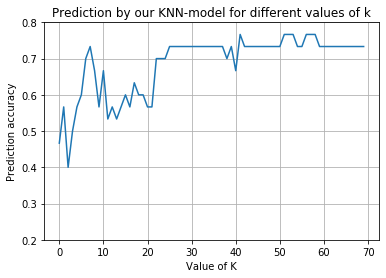

In [118]:
#Here I simply create the plot
plt.plot
plt.ylabel('Prediction accuracy')
plt.xlabel('Value of K')
plt.title('Prediction by our KNN-model for different values of k')
plt.ylim(0.2,0.8)
plt.plot(acc)
plt.grid()
plt.show()

In [119]:
knn = knn_model_constructor(11,np_data, label)

In [120]:
scores = cross_val_score(knn, np_data, label, cv=5)

In [121]:
# Here we print the average score from the cross validation
sum(scores)/5

0.6171894697812383

## Test 03 with color as an int

In [122]:
data = backup.copy()

In [123]:
data

,label,image_id,real_area,real_perimeter,calculated_area,calculated_perimeter,compactness,average_rgb,deviation_of_colour,average_luminosity,deviation_luminosity
0,0,ISIC_0001769,216160,2013,216160,3982.0,1.491772,"[162.07149333826794, 99.30780440414507, 67.786...","[12.205123532436513, 18.754262929408846, 19.89...",114.480686,11.817479
1,0,ISIC_0001852,130493,1372,130493,2718.0,1.147919,"[116.74907466300874, 54.64894668679546, 33.087...","[31.27789052350099, 32.07510414646571, 25.0998...",70.758871,21.216643
2,0,ISIC_0001871,205116,1720,205116,3412.0,1.147751,"[182.21681390042707, 134.7412049766961, 102.53...","[6.3898744270946, 12.975379982675513, 19.33878...",145.265327,8.156129
3,0,ISIC_0003462,161705,1344,161705,2683.0,0.888925,"[165.82234315574658, 116.78643826721499, 87.55...","[13.467871330386464, 27.312125552850148, 34.95...",128.115611,17.003706
4,0,ISIC_0003539,317040,2063,317040,4120.0,1.068254,"[165.12712276053495, 99.63897930860459, 63.168...","[23.770632535623616, 33.005983134923085, 30.47...",115.062269,20.927490
...,...,...,...,...,...,...,...,...,...,...,...
145,0,ISIC_0015443,9732988,13775,9732988,27463.0,1.551412,"[139.39421737702747, 89.18466076399149, 63.660...","[14.693926319508012, 21.175403762962702, 27.40...",101.287584,13.548701
146,0,ISIC_0015445,12049938,19517,12049938,39025.0,2.515541,"[154.57732197460268, 91.72927727926898, 82.038...","[47.62813987684408, 41.48168846201185, 40.1837...",109.416063,28.577897
147,0,ISIC_0015483,8856478,13813,8856478,27534.0,1.714372,"[142.42447065300675, 105.85834335048311, 92.20...","[38.30387070156361, 34.627307043981304, 33.481...",115.234832,23.640907
148,0,ISIC_0015496,8951522,13742,8951522,27392.0,1.678778,"[172.3990948131502, 98.74436403105528, 77.7044...","[71.20114045798132, 56.41305374592664, 50.9847...",118.368574,39.794190


In [124]:
# Here we convert the 
hex_val = from_rgb_to_int(data['average_rgb'])
data['average_rgb'] = hex_val
hex_val = from_rgb_to_int(data['deviation_of_colour'])
data['deviation_of_colour'] = hex_val
for elm in data.iloc[:,2:]:
    data[elm] = np.log10(data[elm])

In [125]:
np_data = np.array(data.iloc[:,2:])

In [126]:
label = np.array(data.iloc[:,0:1])

In [127]:
label = [int(x) for x in label]

In [128]:
x_train, x_test, y_train, y_test = train_test_split(np_data,label,test_size=0.2, random_state = 4)

In [129]:
# Here we make a accuacy score for 
acc = []
for i in range(1,71):
    pred = make_knn_prediction(i) #Here i create the prediction and appending it
    acc.append((accuracy_score(y_test, pred)))

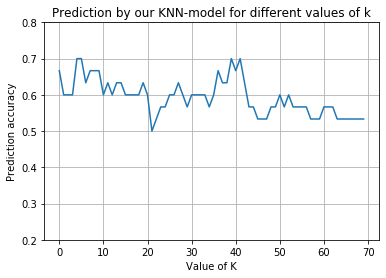

In [130]:
#Here I simply create the plot
plt.plot
plt.ylabel('Prediction accuracy')
plt.xlabel('Value of K')
plt.title('Prediction by our KNN-model for different values of k')
plt.ylim(0.2,0.8)
plt.plot(acc)
plt.grid()
plt.show()

In [131]:
knn = knn_model_constructor(11,np_data, label)

In [132]:
scores = cross_val_score(knn, np_data, label, cv=5)

In [133]:
# Here we print the average score from the cross validation
sum(scores)/5

0.5173303670745273

### Test 02 using log on the df

In [134]:
data = backup.copy()

In [135]:
hex_val = from_rgb_to_int(data['average_rgb'])
data['average_rgb'] = hex_val

In [136]:
hex_val = from_rgb_to_int(data['deviation_of_colour'])
data['deviation_of_colour'] = hex_val

In [137]:
for elm in data.iloc[:,2:]:
    data[elm] = np.log10(data[elm])

In [138]:
data

,label,image_id,real_area,real_perimeter,calculated_area,calculated_perimeter,compactness,average_rgb,deviation_of_colour,average_luminosity,deviation_luminosity
0,0,ISIC_0001769,5.334775,3.303844,5.334775,3.600101,0.173702,7.027033,5.898209,2.058732,1.072525
1,0,ISIC_0001852,5.115587,3.137354,5.115587,3.434249,0.059911,6.881729,6.309595,1.849781,1.326677
2,0,ISIC_0001871,5.312000,3.235528,5.312000,3.533009,0.059847,7.077802,5.598032,2.162162,0.911484
3,0,ISIC_0003462,5.208723,3.128399,5.208723,3.428621,-0.051135,7.035158,5.933950,2.107602,1.230544
4,0,ISIC_0003539,5.501114,3.314499,5.501114,3.614897,0.028675,7.034983,6.180644,2.060933,1.320717
...,...,...,...,...,...,...,...,...,...,...,...
145,0,ISIC_0015443,6.988246,4.139092,6.988246,4.438748,0.190727,6.960583,5.965158,2.005556,1.131898
146,0,ISIC_0015445,7.080985,4.290413,7.080985,4.591343,0.400631,7.005005,6.490061,2.039081,1.456030
147,0,ISIC_0015483,6.947261,4.140288,6.947261,4.439869,0.234105,6.970025,6.397785,2.061584,1.373664
148,0,ISIC_0015496,6.951897,4.138050,6.951897,4.437624,0.224993,7.052977,6.669079,2.073236,1.599820


In [139]:
np_data = np.array(data.iloc[:,2:])

In [140]:
label = np.array(data.iloc[:,0:1])

In [141]:
label = [int(x) for x in label]

In [142]:
x_train, x_test, y_train, y_test = train_test_split(np_data,label,test_size=0.2, random_state = 4)

In [143]:
# Here we make a accuacy score for 
acc = []
for i in range(1,71):
    pred = make_knn_prediction(i) #Here i create the prediction and appending it
    acc.append((accuracy_score(y_test, pred)))

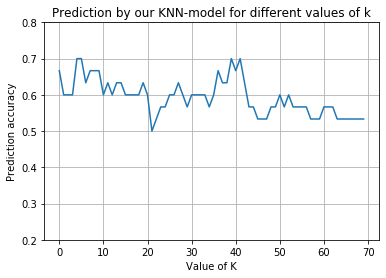

In [144]:
#Here I simply create the plot
plt.plot
plt.ylabel('Prediction accuracy')
plt.xlabel('Value of K')
plt.title('Prediction by our KNN-model for different values of k')
plt.ylim(0.2,0.8)
plt.plot(acc)
plt.grid()
plt.show()

In [145]:
knn = knn_model_constructor(11,np_data,label)

In [146]:
scores = cross_val_score(knn, np_data, label, cv=5)

In [147]:
# Here we print the average score from the cross validation
sum(scores)/5

0.5173303670745273

## Test 04 

In [ ]:
#Here we load the data
#The list has the following structure
#['id','np_array of a picture','the mask of the picture']

In [ ]:
#Training data is structured the following way
#['np_array of a picture','label']
#In our case 
#0 == melanoma
#1 == keratosis

In [ ]:
mask = ground_truth['melanoma'] == 1
melanoma_mask = ground_truth[mask]

total_data = []
melanoma_data = []
keratosis_data = []
training_data = []
x = 0

for image_id in ground_truth['image_id']:
    print(image_id,x)
    image = plt.imread('../data/example_image/'+image_id+'.jpg') # Here we load the image
    image_seg = plt.imread('../data/example_segmentation/'+image_id+'_segmentation.png') # Here we load the mask
    if image_id in list(melanoma_mask['image_id']): # If the image id is in the melanoma list, label it as melanoma
        melanoma_data.append((image_id,image,image_seg)) #else label it as keratosis
        training_data.append((image,0))
    else:
        keratosis_data.append((image_id,image,image_seg))
        training_data.append((image,1))
    total_data.append((image_id,image,image_seg)) #Here we have a list of all the data together
    x += 1

In [ ]:
len(melanoma_data)

In [ ]:
len(keratosis_data)

In [ ]:
#read file
file_input = pd.read_csv("../data/example_ground_truth.csv")
file_input.shape

In [ ]:
# data frame for images with no diagnosis
non_malignant_df = file_input.loc[(file_input['melanoma'] == 0.0) & (file_input["seborrheic_keratosis"] == 0.0)]
non_malignant_df

In [ ]:
#filter out all images that are not melanoma
melanoma = file_input[file_input["melanoma"] == 1.0]

#remove column for keratosis
melanoma_df = melanoma.drop(["seborrheic_keratosis"], axis = 1)
melanoma_df

In [ ]:
#number of images left
melanoma.shape

In [ ]:
#read file features
file_features_df = pd.read_csv("../features/features.csv")
file_features_df.shape

#150 rows, 3 columns

In [ ]:
#data frame for features
file_features_df

In [ ]:
#rename column 'id' to 'image_id'
file_features_df.rename(columns={'id': 'image_id'}, inplace=True)

#merge data frame for file_features_df with melanoma by column 'image_id'
merge_feature_melanoma = file_features_df.merge(melanoma_df, on='image_id', how='right')

In [ ]:
#data frame for merged features and melanoma
#this data frame shows only data related to melanoma 

merge_feature_melanoma

In [ ]:
# size of data frame
merge_feature_melanoma.shape

In [ ]:
merge_feature_non_malignant_df = file_features_df.merge(non_malignant_df, on='image_id', how='right')
#Here we use the function isna() to check for missing values in the different columns
merge_feature_non_malignant_df.isna().any()

In [ ]:
merge_feature_non_malignant_df

In [ ]:
all_feature_merge = file_features_df.merge(file_input, on='image_id', how='right')

## Final DF

In [ ]:
#Export features from images
data = pd.DataFrame()
count = 0
rows = []
for image_id in all_feature_merge['image_id']:
    print(image_id,count)
    
    image = plt.imread('../data/example_image/'+image_id+'.jpg')
    image_seg = plt.imread('../data/example_segmentation/'+image_id+'_segmentation.png')
    #data['image_id'] = image_id
    real_area = int(all_feature_merge[all_feature_merge['image_id'] == image_id]['area'])
    real_perimeter = int(all_feature_merge[all_feature_merge['image_id'] == image_id]['perimeter'])
    melanoma = int(all_feature_merge[all_feature_merge['image_id'] == image_id]['melanoma'])
    seborrheic_keratosis = int(all_feature_merge[all_feature_merge['image_id'] == image_id]['seborrheic_keratosis'])
    thing = (all_feature_merge['image_id'] == image_id)
    all_feature_merge
    #label = int(all_feature_merge[all_feature_merge['image_id'] == image_id])
    calculated_area = int(calculate_area(image_seg))
    calculated_perimeter = calculate_border(image_seg,2)
    imgCompactness = compactness(calculate_area(image_seg),calculate_border(image_seg,1))
    average_rgb = average_colour(image,image_seg)
    deviation_of_rgb = deviation_of_colour(image,image_seg)
    average_luminosity_img = average_luminosity(image,image_seg)
    deviation_luminosity_img = deviation_luminosity(image,image_seg)
    row = [image_id, real_area, real_perimeter, label,melanoma,seborrheic_keratosis,calculated_area,calculated_perimeter,imgCompactness,average_rgb,deviation_of_rgb,average_luminosity_img,deviation_luminosity_img]
    rows.append(row)
    count+= 1

data = pd.DataFrame(rows, columns = ['image_id','real_area','real_perimeter', 'label','melanoma','seborrheic_keratosis','calculated_area','calculated_perimeter','compactness','average_rgb','deviation_of_colour','average_luminosity','deviation_luminosity'])

In [ ]:
Counter(data['seborrheic_keratosis'])

In [ ]:
Counter(data['melanoma'])

In [ ]:
data

In [ ]:
X = 

In [ ]:
x = raw_data[:,:4] #I chose the first 4 columns
y = raw_data[:,-1]#I chose the last column
print(x.shape,y.shape)

In [ ]:
# Here we use our functions area and border to calculate the compactness of the first image
area1 = calculate_area(melanoma_data[0][2])
border1 = calculate_border(melanoma_data[0][2],4)
compactness(area1,border1)

In [ ]:


#Structural element, that we will use as a "brush" on our mask
struct_el = morphology.disk(4)

mask_eroded = morphology.binary_erosion(melanoma_data[0][2], struct_el)

# Show side by side

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].imshow(melanoma_data[0][2][500:1200,1000:2000], cmap='gray')
#axes[1].imshow(mask_eroded, cmap='gray')
fig.tight_layout()

# Verify it's smaller
#print(area)
print(calculate_area(melanoma_data[0][2])-np.sum(mask_eroded))
border = melanoma_data[0][2]-mask_eroded
plt.imshow(border[500:1200,1000:2000])


In [ ]:
def masking(image,mask):
    mask2 = mask == 0
    copy = image.copy()
    copy[mask2] = [0,0,0]
    return copy
test = masking(total_data[0][1],total_data[0][2])

In [ ]:
mask2 = total_data[0][2] == 0
copy = total_data[0][1].copy()
copy[mask2] = [0,0,0]

In [ ]:
plt.imshow(test)

In [ ]:
image = test

In [ ]:
modified_image = cv2.resize(image, (600, 400), interpolation = cv2.INTER_AREA)
modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3)

In [ ]:
modified_image

In [ ]:
number_of_colors = 5

In [ ]:
clf = KMeans(n_clusters = number_of_colors)
labels = clf.fit_predict(modified_image)

In [ ]:
counts = Counter(labels)

In [ ]:
len(labels)

In [ ]:
len(labels)/600

In [ ]:
labels.resize(600,400)

In [ ]:
labels

In [ ]:
plt.imshow(labels)

In [ ]:

center_colors = clf.cluster_centers_
# We get ordered colors by iterating through the keys
ordered_colors = [center_colors[i] for i in counts.keys()]
hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
rgb_colors = [ordered_colors[i] for i in counts.keys()]

In [ ]:
color_list = []
color_count = []
for elm in zip(counts.values(),hex_colors):
    if elm[1] == '#000000':
        None
    else:
        color_list.append(elm[1])
        color_count.append(elm[0])

In [ ]:
plt.figure(figsize = (8, 6))
plt.pie(color_count, labels = color_list, colors = color_list);

In [ ]:
for elm in zip(counts.values(),hex_colors):
    print(elm)

In [ ]:
color_data = [list(elm) for elm in zip(counts.values(),hex_colors) ]

In [ ]:
color_data

In [ ]:
counter = 0
for elm in color_data:
    placeholder = ImageColor.getcolor(elm[1], "RGB")
    color_data[counter][1] = placeholder
    counter += 1

In [ ]:
color_data

In [ ]:
random.seed(420)

In [ ]:
img = mpimg.imread(r'C:\Users\tjupp\Desktop\ITU\Intro_programing\Exercise24\ex24pick.png',0)
data = img[:,:,:3]
plt.imshow(data)

In [ ]:
data.shape

In [ ]:
data = (total_data[0][1][600:1200,1300:2100])
plt.imshow(data)

In [ ]:
img.shape

In [ ]:
total_data[0][1][0][0]

In [ ]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

grey_image = rgb2gray(total_data[0][1])

In [ ]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

gray = rgb2gray(im)
plt.imshow(gray, cmap='gray')

In [ ]:
grey_image.shape

In [ ]:
plt.imshow(grey_image)

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(grey_image)

In [ ]:
kmeans.labels_

In [ ]:
amount_of_clusters = 5
n_dimensions = 3
def getcentroids(amount_of_clusters,n_dimensions,minpoint,maxpoint):
    centroids = []
    for i in range(amount_of_clusters):
        li = []
        for x in range(n_dimensions):
            li.append(random.randint(minpoint,maxpoint))
        centroids.append(li)
    return centroids

#centroids = getcentroids(amount_of_clusters,n_dimensions,0,255)
#print(centroids)

In [ ]:
def distance(pointA,pointB):
    #This function calculates the distance between two points of n dimensions
    li = []
    for elm in zip(pointA, pointB):
        li.append((elm[0]-elm[1])**2)
    return math.sqrt(sum(li))

In [ ]:

def linkpointtocentroid(data,centroids):
    #This labels all the pixels with the label closest to a centroid
    final_list = []
    for k in data:
        placeholder = []
        for i in k:
            label = 1
            max_val = float('inf')
            li = 0
            for elm in centroids: 
                if max_val > distance(i, elm):
                    max_val = distance(i,elm)
                    li = label
                label += 1
            placeholder.append(li)
        final_list.append(placeholder)
    final_list = np.array(final_list)
    return final_list
#linkpointtocentroid(data,centroids)

#labels = linkpointtocentroid(data,centroids)




#labels, points_linked_to_centroid = linkpointtocentroid(data,centroids)
#only uncomment line above once you get to step 3
#print(labels.shape)
#print(len(points_linked_to_centroid_dict))

#print(np.unique(labels))
#print(labels)
#plt.imshow(labels)

In [ ]:
#labels.shape